In [ ]:
# Installing packages that do not come as default with Google Colab
!pip install yfinance
!pip install mplfinance

In [6]:
# Importing necessary python libraries for this project
import pandas as pd
import numpy as np
import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [52]:
# Obtaining historical stock pricing data
ticker_symbol = 'TCS.NS'
ticker = yfinance.Ticker(ticker_symbol)

start_date = None # '2022-01-01'
end_date = None #'2022-11-14'

# period = "1mo"
# interval = "15m"

period = "2y"
interval = "1d"

df = ticker.history(interval=interval, period=period, start=start_date, end=end_date)

df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

df

,Date,Open,High,Low,Close
Date,,,,,
2020-11-14 00:00:00+05:30,18579.770833,2612.960584,2623.742466,2595.495082,2605.545166
2020-11-17 00:00:00+05:30,18582.770833,2629.596748,2629.596748,2585.737659,2601.349365
2020-11-18 00:00:00+05:30,18583.770833,2596.421996,2599.544290,2543.781320,2562.905518
2020-11-19 00:00:00+05:30,18584.770833,2573.004407,2611.204206,2567.003752,2572.906738
2020-11-20 00:00:00+05:30,18585.770833,2590.567838,2611.058205,2563.784049,2595.690430
...,...,...,...,...,...
2022-11-07 00:00:00+05:30,19302.770833,3229.000000,3242.800049,3195.100098,3233.699951
2022-11-09 00:00:00+05:30,19304.770833,3249.800049,3249.800049,3201.649902,3216.050049
2022-11-10 00:00:00+05:30,19305.770833,3170.000000,3225.000000,3170.000000,3205.649902


C:\Users\Sachin\AppData\Local\Temp\2\ipykernel_5812\524769241.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


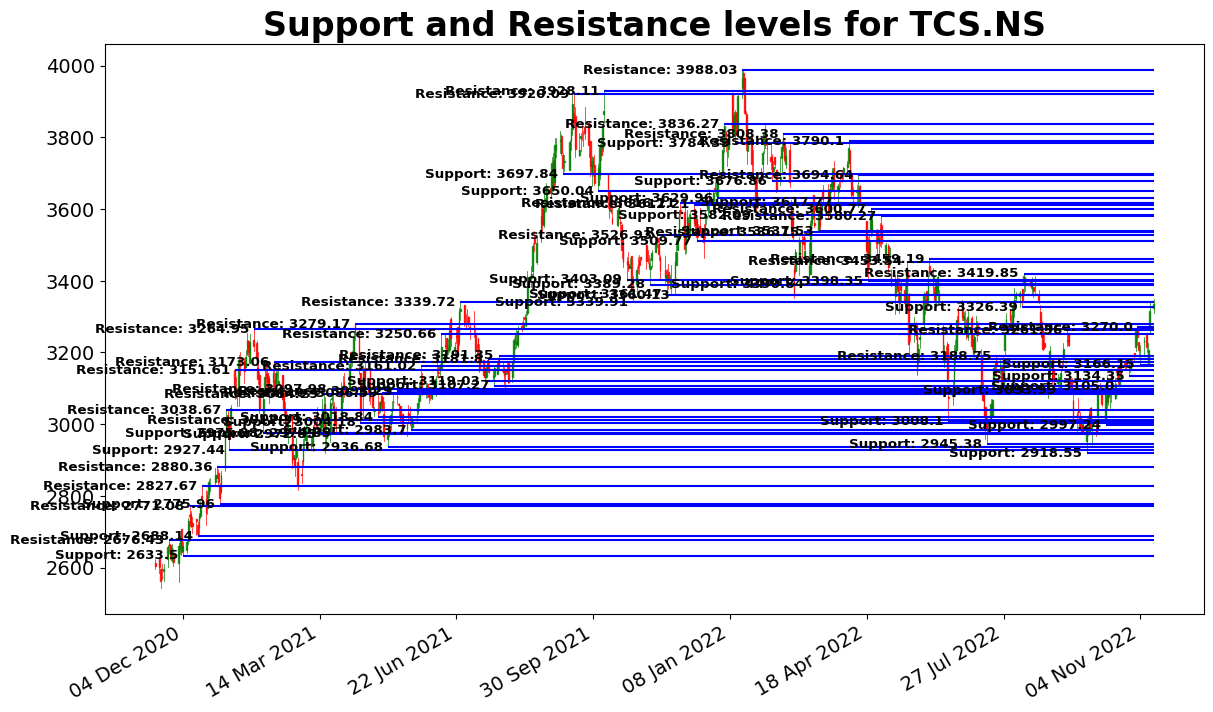

In [53]:
# Create two functions to calculate if a level is SUPPORT or a RESISTANCE level through fractal identification
def is_Suppport_Level(df, i):
  support = df['Low'][i] < df['Low'][i - 1] and df['Low'][i] < df['Low'][i + 1] and df['Low'][i + 1] < df['Low'][i + 2] and df['Low'][i - 1] < df['Low'][i - 2]
  return support


def is_Resistance_Level(df, i):
  resistance = df['High'][i] > df['High'][i - 1] and df['High'][i] > df['High'][i + 1] and df['High'][i + 1] > df['High'][i + 2] and df['High'][i - 1] > df['High'][i - 2]
  return resistance

# Creating a list and feeding it the identified support and resistance levels via the Support and Resistance functions
levels = []
level_types = []
for i in range(2, df.shape[0] - 2):

  if is_Suppport_Level(df, i):
    levels.append((i, df['Low'][i].round(2)))
    level_types.append('Support')

  elif is_Resistance_Level(df, i):
    levels.append((i, df['High'][i].round(2)))
    level_types.append('Resistance')

# Plotting the data
def plot_levels():
  fig, ax = plt.subplots()
  candlestick_ohlc(ax, df.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()

  for level, level_type in zip(levels, level_types):
    plt.hlines(level[1],
               xmin = df['Date'][level[0]],
               xmax = max(df['Date']),
               colors = 'blue')
    plt.text(df['Date'][level[0]], level[1], (str(level_type) + ': ' + str(level[1]) + ' '), ha='right', va='center', fontweight='bold', fontsize='x-small')
    plt.title('Support and Resistance levels for ' + ticker_symbol, fontsize=24, fontweight='bold')
    fig.show()

plot_levels()

In [54]:
# Clean noise in data by discarding a level if it is near another
# (i.e. if distance to the next level is less than the average candle size for any given day - this will give a rough estimate on volatility)
mean = np.mean(df['High'] - df['Low'])

# This function, given a price value, returns True or False depending on if it is too near to some previously discovered key level.
def distance_from_mean(level):
  return np.sum([abs(level - y) < mean for y in levels]) == 0

C:\Users\Sachin\AppData\Local\Temp\2\ipykernel_5812\524769241.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


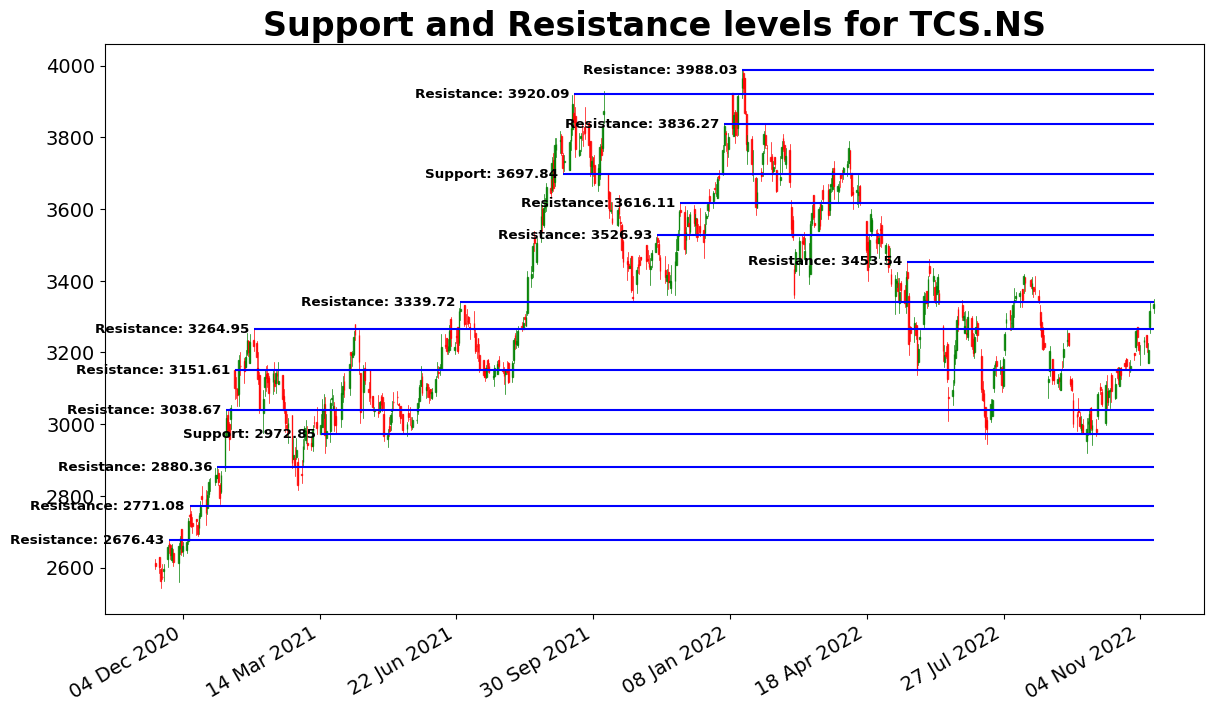

In [55]:
# Optimizing the analysis by adjusting the data and eliminating the noise from volatility that is causing multiple levels to show/overlapp
levels = []
level_types = []
for i in range(2, df.shape[0] - 2):

  if is_Suppport_Level(df, i):
    level = df['Low'][i].round(2)

    if distance_from_mean(level):
      levels.append((i, level))
      level_types.append('Support')

  elif is_Resistance_Level(df, i):
    level = df['High'][i].round(2)

    if distance_from_mean(level):
      levels.append((i, level))
      level_types.append('Resistance')
      
plot_levels()